In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
from torch.backends import cudnn

In [2]:
pkm_dataset_url = "https://raw.githubusercontent.com/c-brugo/pkm-science/main/data/Pokemon.csv"
pkm_matchup_url = "https://raw.githubusercontent.com/c-brugo/pkm-science/main/data/PokeTypeMatchupData.csv"

In [3]:
pkm_df = pd.read_csv(pkm_dataset_url)
pkm_df.head()

,N,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp Atk,Sp Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False


In [4]:
pkm_mu_df = pd.read_csv(pkm_matchup_url)
pkm_mu_df.head()

,Name,Number,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Bulbasaur,#001,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
1,Ivysaur,#002,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
2,Venusaur,#003,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
3,Charmander,#004,*1,*0.5,*2,*1,*0.5,*0.5,*1,*1,*2,*1,*1,*0.5,*2,*1,*1,*1,*0.5,*0.5
4,Charmeleon,#005,*1,*0.5,*2,*1,*0.5,*0.5,*1,*1,*2,*1,*1,*0.5,*2,*1,*1,*1,*0.5,*0.5


In [5]:
filter_alola = pkm_mu_df["Name"].str.contains("Alola")
pkm_mu_df = pkm_mu_df[~filter_alola]
filter_galar = pkm_mu_df["Name"].str.contains("Galarian")
pkm_mu_df = pkm_mu_df[~filter_galar]

In [6]:
pkm_df["Type 2"].fillna("None", inplace=True)
pkm_df.head()

,N,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp Atk,Sp Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,4,Charmander,Fire,None,309,39,52,43,60,50,65,1,False
4,5,Charmeleon,Fire,None,405,58,64,58,80,65,80,1,False


In [7]:
pkm_df = pkm_df[pkm_df["Type 2"]=="None"]
pkm_df.head()

,N,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp Atk,Sp Def,Speed,Generation,Legendary
3,4,Charmander,Fire,None,309,39,52,43,60,50,65,1,False
4,5,Charmeleon,Fire,None,405,58,64,58,80,65,80,1,False
6,7,Squirtle,Water,None,314,44,48,65,50,64,43,1,False
7,8,Wartortle,Water,None,405,59,63,80,65,80,58,1,False
8,9,Blastoise,Water,None,530,79,83,100,85,105,78,1,False


In [8]:
types = ["Normal", "Fire", "Water", "Electric", "Grass", "Ice", "Fighting", "Poison", "Ground", "Flying",
        "Psychic", "Bug", "Rock", "Ghost", "Dragon", "Dark", "Steel", "Fairy"]
types_map = {type_name : i for i, type_name in enumerate(types)}

In [9]:
pkm_mu_df.replace(to_replace = "[#, *]", value = "", regex = True, inplace = True)
pkm_mu_df["Number"] = pkm_mu_df["Number"].astype(int)

pkm_mu_df[types]=pkm_mu_df[types].astype(float)

pkm_mu_df.head()

,Name,Number,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Bulbasaur,1,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,Ivysaur,2,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,Venusaur,3,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
3,Charmander,4,1.0,0.5,2.0,1.0,0.50,0.5,1.0,1.0,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5
4,Charmeleon,5,1.0,0.5,2.0,1.0,0.50,0.5,1.0,1.0,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5


In [10]:
pkm_muT_df = pd.merge(pkm_df[["N", "Name", "Type 1"]], pkm_mu_df[["Number", "Name"] + types],  how="inner", left_on=["N", "Name"], right_on = ["Number", "Name"])
del pkm_muT_df["Number"]
pkm_muT_df

,N,Name,Type 1,Normal,Fire,Water,Electric,Grass,Ice,Fighting,...,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,4,Charmander,Fire,1.0,0.5,2.0,1.0,0.5,0.5,1.0,...,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5
1,5,Charmeleon,Fire,1.0,0.5,2.0,1.0,0.5,0.5,1.0,...,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5
2,7,Squirtle,Water,1.0,0.5,0.5,2.0,2.0,0.5,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
3,8,Wartortle,Water,1.0,0.5,0.5,2.0,2.0,0.5,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
4,9,Blastoise,Water,1.0,0.5,0.5,2.0,2.0,0.5,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,704,Goomy,Dragon,1.0,0.5,0.5,0.5,0.5,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0
189,705,Sliggoo,Dragon,1.0,0.5,0.5,0.5,0.5,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0
190,706,Goodra,Dragon,1.0,0.5,0.5,0.5,0.5,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0
191,712,Bergmite,Ice,1.0,2.0,1.0,1.0,1.0,0.5,2.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0


In [11]:
pkm_muT_df = pkm_muT_df[["Type 1"] + types].drop_duplicates().reset_index(drop=True)
pkm_muT_df

,Type 1,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Fire,1.0,0.5,2.0,1.0,0.5,0.5,1.0,1.0,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5
1,Water,1.0,0.5,0.5,2.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
2,Bug,1.0,2.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0
3,Electric,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
4,Ground,1.0,1.0,2.0,0.0,2.0,2.0,1.0,0.5,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0
5,Fairy,1.0,1.0,1.0,1.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,1.0,1.0,0.0,0.5,2.0,1.0
6,Normal,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
7,Psychic,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,2.0,1.0,2.0,1.0,2.0,1.0,1.0
8,Fighting,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.5,0.5,1.0,1.0,0.5,1.0,2.0
9,Poison,1.0,1.0,1.0,1.0,0.5,1.0,0.5,0.5,2.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,0.5


In [12]:
pkm_muT_single_df = pd.melt(pkm_muT_df, id_vars="Type 1", value_vars=types, var_name="Move", value_name="Matchup")
pkm_muT_single_df

,Type 1,Move,Matchup
0,Fire,Normal,1.0
1,Water,Normal,1.0
2,Bug,Normal,1.0
3,Electric,Normal,1.0
4,Ground,Normal,1.0
...,...,...,...
301,Dark,Fairy,2.0
302,Ghost,Fairy,1.0
303,Ice,Fairy,1.0
304,Steel,Fairy,0.5


In [13]:
def extraction(x, n):
  
  for i in range(20):
    weak = x[x["Matchup"]>1].sample(1)
    res = x[x["Matchup"]<1].sample(1)

    neut = x[x["Matchup"]==1].sample(1)
    weak_val = weak["Move"].values[0]

    res_val = res["Move"].values[0]
    neut_val = neut["Move"].values[0]

    remaining_filter = x["Move"].str.contains(weak_val) | x["Move"].str.contains(res_val) | x["Move"].str.contains(neut_val)
    remaining = x[~remaining_filter].sample(n-3)

    result = pd.concat([weak, res, neut, remaining]).sample(frac=1)

    move_numbers = ["Move{}".format(i) for i in range(n)]
    result.insert(2, "MoveN", move_numbers)

    mu_numbers = ["Matchup{}".format(i) for i in range(n)]
    result.insert(4, "MatchupN", mu_numbers)

    result_move = result[["Type 1", "MoveN", "Move"]].pivot(index="Type 1", columns="MoveN")["Move"].reset_index()
    result_mu = result[["Type 1", "MatchupN", "Matchup"]].pivot(index="Type 1", columns="MatchupN")["Matchup"].reset_index()

    result = pd.merge(result_move, result_mu,  how="inner", left_on = "Type 1", right_on = "Type 1")

    if i==0:
      result_final = pd.DataFrame(result)
    else:
      result_final = result_final.append(result, ignore_index=True)

  return result_final

In [29]:
n_moves=4
yX = pkm_muT_single_df.groupby("Type 1").apply(extraction, n=n_moves).reset_index(drop=True)
yX

,Type 1,Move0,Move1,Move2,Move3,Matchup0,Matchup1,Matchup2,Matchup3
0,Bug,Rock,Psychic,Fighting,Water,2.0,1.0,0.5,1.0
1,Bug,Ice,Dark,Ground,Rock,1.0,1.0,0.5,2.0
2,Bug,Ghost,Grass,Poison,Flying,1.0,0.5,1.0,2.0
3,Bug,Fighting,Rock,Water,Dragon,0.5,2.0,1.0,1.0
4,Bug,Dark,Ice,Flying,Ground,1.0,1.0,2.0,0.5
...,...,...,...,...,...,...,...,...,...
335,Water,Dark,Steel,Grass,Bug,1.0,0.5,2.0,1.0
336,Water,Normal,Electric,Water,Psychic,1.0,2.0,0.5,1.0
337,Water,Poison,Electric,Bug,Fire,1.0,2.0,1.0,0.5
338,Water,Grass,Rock,Ice,Flying,2.0,1.0,0.5,1.0


In [30]:
yX = yX.replace(types_map)
Y = yX["Type 1"]
X = yX.drop("Type 1", axis=1)

# Model

In [31]:
DEVICE = 'cuda'

BATCH_SIZE = 16

LR = 1e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5

NUM_EPOCHS = 50
STEP_SIZE = 20
GAMMA = 0.1

In [32]:
class Data(Dataset):
  def __init__(self, X, y):
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  
  def __len__(self):
    return self.len

In [33]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.3, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.29, random_state=42)

In [34]:
data_train = Data(X_train, Y_train)
data_val = Data(X_val, Y_val)
data_test = Data(X_test, Y_test)

In [35]:
print(len(data_train))

168


In [36]:
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [37]:
def calc_accuracy(net, dataloader, dataset):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for inputs, labels in dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(inputs)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  if dataloader.drop_last:
    accuracy = running_corrects / float(len(dataloader)*BATCH_SIZE)
  else:
    accuracy = running_corrects / float(len(dataset))
  return accuracy



In [38]:
# number of features (len of X cols)
input_dim = n_moves*2
# number of hidden layers
hidden_layers = 32
# number of classes (unique of y)
output_dim = len(types)

class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_layers)
    self.linear2 = nn.Linear(hidden_layers, output_dim)
    
  def forward(self, x):
    x = self.linear1(x)
    x = torch.sigmoid(x)
    x = self.linear2(x)
    return x

In [39]:
model = Network()

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [41]:
columns = ["epoch", "train_accuracy", "val_accuracy", "loss"]
base_df = pd.DataFrame(index=range(NUM_EPOCHS), columns=columns)

model = model.to(DEVICE)

cudnn.benchmark

current_step = 0
for epoch in range(NUM_EPOCHS):
  if (epoch+1)%5 == 0:
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  loss_epoch = 0.0

  for inputs, labels in train_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    model.train()

    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
    # forward propagation
    outputs = model(inputs)
    #print(inputs)
    loss = criterion(outputs, labels)
    loss_epoch += loss.item() * inputs.size(0)

    # backward propagation
    loss.backward()
    # optimize
    optimizer.step()
  base_df["epoch"][epoch] = epoch+1
  base_df["loss"][epoch] = loss_epoch/float(len(train_loader)*BATCH_SIZE)
  base_df["train_accuracy"][epoch] = calc_accuracy(model, train_loader, data_train)
  base_df["val_accuracy"][epoch] = calc_accuracy(model, val_loader, data_val)
  scheduler.step() 

Starting epoch 5/50, LR = [0.01]
Starting epoch 10/50, LR = [0.01]
Starting epoch 15/50, LR = [0.01]
Starting epoch 20/50, LR = [0.01]
Starting epoch 25/50, LR = [0.001]
Starting epoch 30/50, LR = [0.001]
Starting epoch 35/50, LR = [0.001]
Starting epoch 40/50, LR = [0.001]
Starting epoch 45/50, LR = [0.0001]
Starting epoch 50/50, LR = [0.0001]


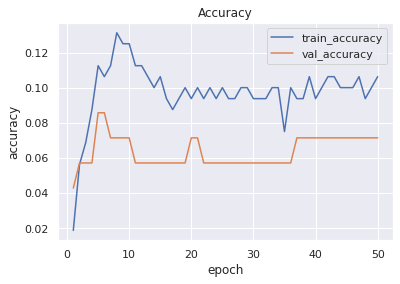

In [42]:
plt.figure()
plt.plot('epoch', 'train_accuracy', data=base_df)
plt.plot('epoch', 'val_accuracy', data=base_df)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

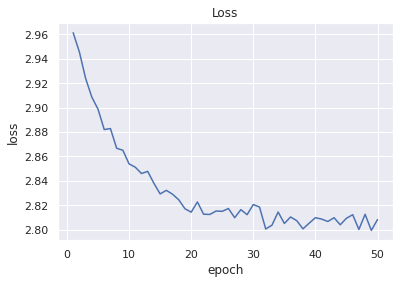

In [43]:
plt.figure()
plt.plot('epoch', 'loss', data=base_df)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.show()